In [1]:
import moleculegraph
import numpy as np
from jinja2 import Template
import toml 

# Generate GROMACS inputs with moleculegraph

This notebook shows generate GROMACS inputs with moleculegraph.

## 1) Get moleculegraph

Generate a moleculegraph object from a molecule string.

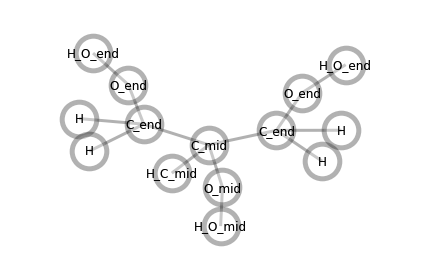

In [2]:
molecule_string = "[H_O_end][O_end][C_end][b1][H][b1][H][C_mid][b1][H_C_mid][b2][O_mid][H_O_mid][C_end][b1][H][b1][H][O_end][H_O_end]"

molecule = moleculegraph.molecule(molecule_string)

molecule.visualize(saveto="test")

## 2) Get force field

Get the force field in form of a dict.

Here: from a toml file.

Tipp: have a look on the force field toml and the obtained dict.

In [3]:
ff_file = "ff_test_GROMACS.toml"
with open(ff_file) as toml_file:
    ff = toml.load(toml_file)

#ff["atoms"]["H"]
#ff["bonds"]["[C_end][H]"]

## 3) Map force field to molecule

Now we can transport the information from our force field library to the positions where the information is needed in a specific molecule. Force field informationen from the dict are mapped to the molecule graph.

Tipp: have a look on the renderdict.

In [4]:
renderdict = {}

atomtype_dummy             = molecule.map_molecule( molecule.unique_atom_keys, ff["atoms"] )
renderdict["atomtypes"]    = list( zip( molecule.unique_atom_numbers+1, atomtype_dummy  ) ) 

bond_dummy                 = molecule.map_molecule( molecule.bond_keys , ff["bonds"])
renderdict["bonds"]        = list( zip(molecule.bond_list+1, bond_dummy) )
 
angle_dummy                = molecule.map_molecule( molecule.angle_keys , ff["angles"] )
renderdict["angles"]       = list( zip(molecule.angle_list+1, angle_dummy) )

dihedral_dummy             = molecule.map_molecule( molecule.torsion_keys , ff["dihedrals"] )
renderdict["dihedrals"]    = list( zip(molecule.torsion_list+1, dihedral_dummy) )

improper_dihedrals_dummy   = np.array(molecule.map_molecule( molecule.torsion_keys , ff["improper_dihedrals"] ))
p              = np.where( improper_dihedrals_dummy!=None )
renderdict["improper_dihedrals"] = list( zip(molecule.torsion_list[p]+1, improper_dihedrals_dummy[p]) )

atom_dummy    = molecule.map_molecule( molecule.atom_names, ff["atoms"] )
gmx_atomnames = [ x[0]+str(i) for i,x in enumerate(molecule.atom_names) ]
renderdict["atoms"]    = list( zip( molecule.atom_numbers+1,gmx_atomnames, atom_dummy  ) ) 

renderdict["pairs"] = np.array([ (x[0],x[-1]) for x in molecule.torsion_list+1 ])

## 4) Render template

Finally we can render a template with the molecule specific informations and our force field.

Tipp: have a look on the the and compare template and the rendered result.


In [5]:
with open("GROMACS_emplate.itp") as file_:
    template = Template(file_.read())
rendered = template.render( rd=renderdict ) #Textformat wie in template

dummy = "test.itp"
with open(dummy, "w") as fh:
    fh.write(rendered) 